In [20]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df=pd.read_csv('/content/drive/Shareddrives/IDS561/data_preprocessing_op.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,retweet_count,favorite_count,word_count,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Overall Sentiment,Overall Sentiment Description
0,0,BREAKING: Pfizer ‘Fetal Cell’ Whistleblower M...,0,0,16,0.000001,1.000001,0.000001,0.000001,Neutral
1,1,Toronto lockdown czar’s husband has ‘financia...,0,0,11,0.000001,1.000001,0.000001,0.000001,Neutral
2,2,"&amp; year olds, ""ACCIDENTALLY"" given Pfizer ...",0,0,18,0.000001,0.758001,0.242001,-0.585899,Negative
3,3,You will find here what changes your life for...,0,0,14,0.225001,0.775001,0.000001,0.440401,Neutral
4,4,"When Twitter gives mewarning about anything, ...",0,0,20,0.130001,0.870001,0.000001,0.400501,Neutral


In [21]:
#Setting up drive, installing spark and importing required libraries
%cd /content/drive/Shareddrives/IDS561/
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -v https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!ls
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/Shareddrives/IDS561/spark-3.1.2-bin-hadoop3.2"


/content/drive/Shareddrives/IDS561
--2021-11-21 22:39:07--  https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz.35’

spark-3.1.2-bin-had 100%[===================>] 218.23M  46.8MB/s    in 4.5s    

2021-11-21 22:39:12 (48.8 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz.35’ saved [228834641/228834641]

'1) Data import and consolidate.ipynb'	 spark-3.1.2-bin-hadoop3.2.tgz.18
'2) MissingData .ipynb'			 spark-3.1.2-bin-hadoop3.2.tgz.19
'3) Data_preprocessing.ipynb'		 spark-3.1.2-bin-hadoop3.2.tgz.2
'4 Exploratory_Analysis.ipynb'		 spark-3.1.2-bin-hadoop3.2.tgz.20
'5) Modelling.ipynb'			 spark-3.1.2-bin-hadoop3.2.tgz.21
 Archive				 spark-3.1.2-bin-hadoop3.2.tgz.22
 cleaned_tweets.csv	

In [22]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import nltk
nltk.download('punkt')
import pyspark.sql.functions as f

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
#tweets=spark.createDataFrame(tweets) 
#tweets.show()

df_spark=spark.createDataFrame(df) 
df_spark.show()


+----------+--------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|Unnamed: 0|                text|retweet_count|favorite_count|word_count| Positive Sentiment| Neutral Sentiment| Negative Sentiment|   Overall Sentiment|Overall Sentiment Description|
+----------+--------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|         0| BREAKING: Pfizer...|            0|             0|        16|             1.0E-6|          1.000001|             1.0E-6|              1.0E-6|                      Neutral|
|         1| Toronto lockdown...|            0|             0|        11|             1.0E-6|          1.000001|             1.0E-6|              1.0E-6|                      Neutral|
|         2| &amp; year olds,...|            0|             0|        18|       

In [24]:
#Data cleaning
##################################################steps already done
#RT
#numbers
#spaces
#links
# #-tags
# @
#removed single characters


# rest of the cleaning

# remove punctuations
df_spark = df_spark.withColumn('text', f.regexp_replace('text',r"[^a-zA-Z0-9 ]"," ")) # Removing punctuation from tweet text
df_spark.show(20,truncate=False)




+----------+-------------------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|Unnamed: 0|text                                                                                                                           |retweet_count|favorite_count|word_count|Positive Sentiment |Neutral Sentiment |Negative Sentiment |Overall Sentiment   |Overall Sentiment Description|
+----------+-------------------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|0         | BREAKING  Pfizer  Fetal Cell  Whistleblower Melissa Strickler has been TERMINATED   You are not under any circumst

In [25]:
import pyspark.sql.functions as f
df_spark = df_spark.withColumn("text",f.lower(f.col("text"))) #converting to lowercase
df_spark.show(20,truncate=False)

+----------+-------------------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|Unnamed: 0|text                                                                                                                           |retweet_count|favorite_count|word_count|Positive Sentiment |Neutral Sentiment |Negative Sentiment |Overall Sentiment   |Overall Sentiment Description|
+----------+-------------------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|0         | breaking  pfizer  fetal cell  whistleblower melissa strickler has been terminated   you are not under any circumst

In [26]:
# removing multiple spaces


df_spark = df_spark.withColumn('text', f.regexp_replace('text','  +'," ")) 
df_spark.show(20,truncate=False)

+----------+---------------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|Unnamed: 0|text                                                                                                                       |retweet_count|favorite_count|word_count|Positive Sentiment |Neutral Sentiment |Negative Sentiment |Overall Sentiment   |Overall Sentiment Description|
+----------+---------------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+
|0         | breaking pfizer fetal cell whistleblower melissa strickler has been terminated you are not under any circumstances        |0  

In [27]:
(train_set,test_set) = df_spark.randomSplit([0.8, 0.2], seed = 2000)

In [28]:
train_set.count()
test_set.count()

21895

# HashingTF + IDF

In [29]:
import  pyspark.ml.feature as pys
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
hashtf = HashingTF(numFeatures=2**16, inputCol="words_token", outputCol='tf')
idf  =  pys.IDF(inputCol='tf', outputCol="features", minDocFreq=2) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "Overall Sentiment Description", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])
pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(test_set)
train_df.show(20,truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Models

# 1. Logistic Regression

In [30]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol='label',maxIter=200)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
train_df.select('label').distinct().show()
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator = MulticlassClassificationEvaluator()
roc_auc = (evaluator.evaluate(predictions))
accuracylr = predictions.filter(predictions.label == predictions.prediction).count() / float(val_df.count())
print("Accuracy Score: {0:.4f}".format(accuracylr))
print("ROC-AUC: {0:.4f}".format(roc_auc))

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+

Accuracy Score: 0.9351
ROC-AUC: 0.9352


In [31]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     13356
         1.0       0.92      0.94      0.93      6877
         2.0       0.83      0.84      0.84      1662

    accuracy                           0.94     21895
   macro avg       0.90      0.91      0.91     21895
weighted avg       0.94      0.94      0.94     21895

[[12624   486   246]
 [  393  6448    36]
 [  212    49  1401]]


# 2. Naive Bayes

In [32]:
from pyspark.ml.classification import NaiveBayes
nv = NaiveBayes(smoothing=1.0)
nvModel = nv.fit(train_df)
predictions1 = nvModel.transform(val_df)
train_df.select('label').distinct().show()

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

evaluator = MulticlassClassificationEvaluator()
roc_auc = (evaluator.evaluate(predictions1))

accuracy_nv = predictions1.filter(predictions1.label == predictions1.prediction).count() / float(val_df.count())
print("Accuracy Score: {0:.4f}".format(accuracy_nv))
print("ROC-AUC: {0:.4f}".format(roc_auc))

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+

Accuracy Score: 0.8807
ROC-AUC: 0.8836


In [33]:
y_true = predictions1.select(['label']).collect()
y_pred = predictions1.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     13356
         1.0       0.85      0.91      0.88      6877
         2.0       0.62      0.85      0.72      1662

    accuracy                           0.88     21895
   macro avg       0.81      0.88      0.83     21895
weighted avg       0.89      0.88      0.88     21895

[[11600  1018   738]
 [  481  6270   126]
 [  185    65  1412]]


# 3. Decision Tree

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 6)
dtModel = dt.fit(train_df)
predictions1 = dtModel.transform(val_df)
train_df.select('label').distinct().show()

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

evaluator = MulticlassClassificationEvaluator()
roc_auc = (evaluator.evaluate(predictions1))

accuracy_dt = predictions1.filter(predictions1.label == predictions1.prediction).count() / float(val_df.count())
print("Accuracy Score: {0:.4f}".format(accuracy_dt))
print("ROC-AUC: {0:.4f}".format(roc_auc))

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+

Accuracy Score: 0.6991
ROC-AUC: 0.6376


In [35]:
y_true = predictions1.select(['label']).collect()
y_pred = predictions1.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))


              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80     13356
         1.0       0.98      0.27      0.42      6877
         2.0       0.73      0.13      0.23      1662

    accuracy                           0.70     21895
   macro avg       0.79      0.46      0.48     21895
weighted avg       0.77      0.70      0.64     21895

[[13249    42    65]
 [ 5025  1835    17]
 [ 1437     3   222]]


# Comparison of accuracies of all 3 models






In [36]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Decision Tree']
accuracy = [accuracylr, accuracy_nv, accuracy_dt]

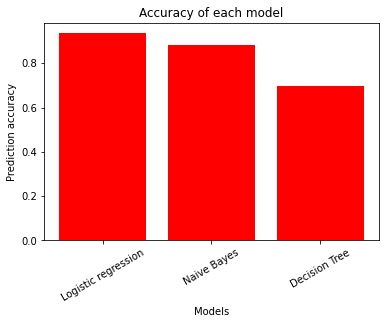

In [37]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy, color = 'red')
    plt.rcParams["figure.figsize"] = (7,5)
    plt.xlabel('Models', fontsize=10)
    plt.ylabel('Prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()

# CountVectorizer + IDF 

In [38]:
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="text", outputCol="words_token")
cv = CountVectorizer(vocabSize=2**16, inputCol="words_token", outputCol='cv')
idf = pys.IDF(inputCol='cv', outputCol="features", minDocFreq=2) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "Overall Sentiment Description", outputCol = "label")
pipeline1 = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx])
pipelineFit1 = pipeline1.fit(train_set)
train_df = pipelineFit1.transform(train_set)
val_df = pipelineFit1.transform(test_set)
train_df.show(20,truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------+-------------+--------------+----------+-------------------+------------------+-------------------+--------------------+-----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Models

# 1. Logistic Regression

In [39]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=200)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
train_df.select('label').distinct().show()
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator = MulticlassClassificationEvaluator()
roc_auc = evaluator.evaluate(predictions)
accuracylr1 = predictions.filter(predictions.label == predictions.prediction).count() / float(val_df.count())
print("Accuracy Score: {0:.4f}".format(accuracylr1))
print("ROC-AUC: {0:.4f}".format(roc_auc))

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+

Accuracy Score: 0.9382
ROC-AUC: 0.9383


In [40]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     13356
         1.0       0.93      0.94      0.93      6877
         2.0       0.84      0.86      0.85      1662

    accuracy                           0.94     21895
   macro avg       0.91      0.92      0.91     21895
weighted avg       0.94      0.94      0.94     21895

[[12657   466   233]
 [  389  6448    40]
 [  184    42  1436]]


# 2. Naive Bayes

In [41]:
from pyspark.ml.classification import NaiveBayes
nv = NaiveBayes(smoothing=1.0)
nvModel = nv.fit(train_df)
predictions1 = nvModel.transform(val_df)
train_df.select('label').distinct().show()

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

evaluator = MulticlassClassificationEvaluator()
roc_auc = (evaluator.evaluate(predictions1))

accuracy_nv1 = predictions1.filter(predictions1.label == predictions1.prediction).count() / float(val_df.count())
print("Accuracy Score: {0:.4f}".format(accuracy_nv1))
print("ROC-AUC: {0:.4f}".format(roc_auc))

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+

Accuracy Score: 0.8815
ROC-AUC: 0.8857


In [42]:
y_true = predictions1.select(['label']).collect()
y_pred = predictions1.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     13356
         1.0       0.86      0.92      0.89      6877
         2.0       0.58      0.88      0.70      1662

    accuracy                           0.88     21895
   macro avg       0.80      0.89      0.83     21895
weighted avg       0.90      0.88      0.89     21895

[[11509   950   897]
 [  389  6329   159]
 [  151    49  1462]]


# 3. Decision Tree

In [43]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 6)
dtModel = dt.fit(train_df)
predictions1 = dtModel.transform(val_df)
train_df.select('label').distinct().show()

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

evaluator = MulticlassClassificationEvaluator()
roc_auc = (evaluator.evaluate(predictions1))

accuracy_dt1 = predictions1.filter(predictions1.label == predictions1.prediction).count() / float(val_df.count())
print("Accuracy Score: {0:.4f}".format(accuracy_dt1))
print("ROC-AUC: {0:.4f}".format(roc_auc))

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+

Accuracy Score: 0.6997
ROC-AUC: 0.6388


In [44]:
y_true = predictions1.select(['label']).collect()
y_pred = predictions1.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80     13356
         1.0       0.97      0.27      0.42      6877
         2.0       0.73      0.13      0.23      1662

    accuracy                           0.70     21895
   macro avg       0.79      0.46      0.48     21895
weighted avg       0.77      0.70      0.64     21895

[[13246    45    65]
 [ 5006  1853    18]
 [ 1437     3   222]]


# Comparison of accuracies of all 6 models

In [45]:
model = ['Logistic regression_td_idf', 'Naive Bayes_td_idf', 'Decision Tree_td_idf', 'Logistic regression_countv', 'Naive Bayes_countv', 'Decision Tree_countv']
accuracy = [accuracylr, accuracy_nv, accuracy_dt, accuracylr1, accuracy_nv1, accuracy_dt1]

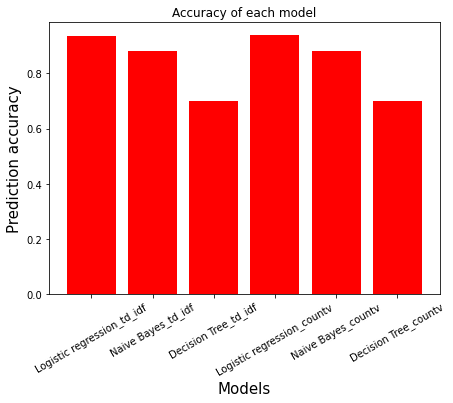

In [46]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy, color = 'red')
    plt.rcParams["figure.figsize"] = (20,5)
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Prediction accuracy', fontsize=15)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()